<a href="https://colab.research.google.com/github/imemmul/Food_classification_EfficientNetB4/blob/main/food_classification_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### My first attempt was a little bit unsuccessful so now I am going to try to use all things that I've got

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8f3bf397-a934-42f2-3a05-7c77d515e623)


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-02 07:59:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-02 07:59:54 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import plot_loss_curves, compare_historys, create_tensorboard_callback

In [5]:
import tensorflow_datasets as tfds

In [6]:
datasets_list = tfds.list_builders()
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete1W7WSJ/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete1W7WSJ/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
len(train_data)

75750

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

#### We have 101 different food types to train

In [9]:
class_names = ds_info.features["label"].names
#adding classes to a variable

In [10]:
train_data_sample_1 = train_data.take(5)

In [11]:
train_data_sample_1

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in train_data_sample_1:
  print(f"""
    Image Shape: {image.shape}
    Image datatype: {image.dtype}
    Target Class: {label}
    class name: {class_names[int(label)]}
  """)


    Image Shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target Class: 77
    class name: pork_chop
  

    Image Shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target Class: 11
    class name: caesar_salad
  

    Image Shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target Class: 96
    class name: tacos
  

    Image Shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target Class: 100
    class name: waffles
  

    Image Shape: (342, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target Class: 18
    class name: chicken_curry
  


Upper print shows us that our data not one-hot encoded so should consider "Sparse" while compiling our model.

In [13]:
import tensorflow as tf

(-0.5, 511.5, 341.5, -0.5)

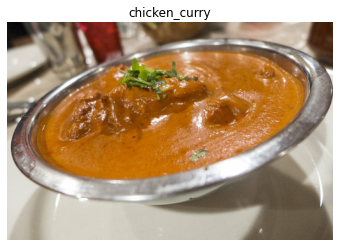

In [14]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[int(label)])
plt.axis(False)

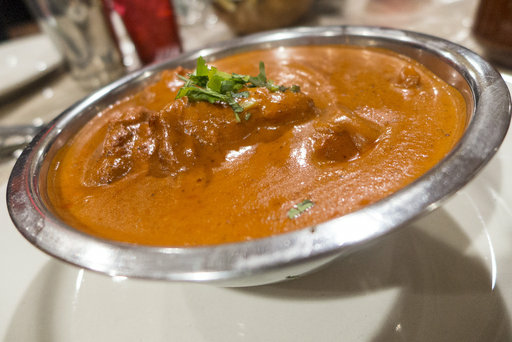

In [15]:
tf.keras.utils.array_to_img(image)

In [18]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [22]:
pre_img = preprocess_img(image, label)[0]
pre_img.shape

TensorShape([224, 224, 3])

## Batching dataset

In [25]:
train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

#shuffle train_data to batch

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [26]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [27]:
len(train_data)

74

In [28]:
74*32

2368

### Creating callbacks

In [29]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [30]:
tf.__version__

'2.8.2'

## Researching Mixed precision training

In [31]:
from tensorflow.keras import mixed_precision

In [36]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [39]:
policy.variable_dtype

'float32'

In [40]:
!nvidia-smi

Fri Sep  2 09:02:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |    286MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------